In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [12]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [13]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [14]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [15]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [16]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [17]:
inspector = inspect(engine)

In [29]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [31]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [57]:
# Find the most recent date in the data set.
most_recent_date = dt.datetime.strptime(session.query(Measurements).order_by(Measurements.date.desc()).first().date, '%Y-%m-%d')
most_recent_date

datetime.datetime(2017, 8, 23, 0, 0)

In [58]:
most_recent_date = session.query(Measurements).order_by(Measurements.date.desc()).first().date.split("-")
most_recent_date

['2017', '08', '23']

In [59]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(int(most_recent_date[0]), \
                     int(most_recent_date[1]), \
                     int(most_recent_date[2])) - dt.timedelta(days=365)
query_date

datetime.date(2016, 8, 23)

In [87]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurements.date, Measurements.prcp]
last_year_results = session.query(*sel).\
                        filter(Measurements.date > query_date).\
                        order_by(Measurements.date).all()
print(last_year_results[0])

('2016-08-24', 0.08)


In [90]:
# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.DataFrame(last_year_results, columns=["date", "prcp"]).set_index('date').fillna(0)

# Sort the dataframe by date
last_year_df = last_year_df.sort_values(['date'])
last_year_df

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,0.00
2016-08-24,1.22
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


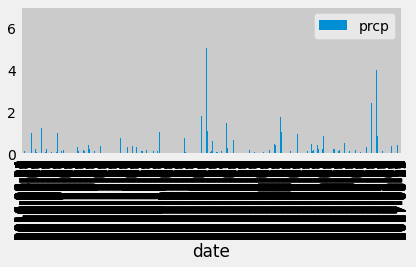

In [84]:
# Use Pandas Plotting with Matplotlib to plot the data
last_year_df.plot.bar()
plt.tight_layout()
plt.show()

In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()